In [282]:
# Configuration - Set crop type and model variant here
crop_type = "soybean"  # Change to "corn", "soybean", or "wheat" as needed
weatherformer_variant = "weatherformersinusoid"  # Change to "weatherformer" or "weatherformersinusoid" as needed
country_name = "usa"

# Dynamic year string based on country
YEAR_STR = "year_10" if country_name == "mexico" else "year_15"

# Extreme years for each crop (used for cross-validation)
EXTREME_YEARS = {
    "usa": {
        "corn": [2002, 2004, 2009, 2012, 2014],
        "soybean": [2003, 2004, 2009, 2012, 2016],
    },
    "argentina": {
        "corn": [2004, 2005, 2007, 2009, 2015],
        "soybean": [2003, 2006, 2007, 2009, 2015],
        "wheat": [2002, 2003, 2005, 2009, 2011],
        "sunflower": [2002, 2007, 2008, 2009, 2011],
    },
    "brazil": {
        "corn": [2001, 2003, 2007, 2010, 2015],
        "soybean": [2001, 2003, 2005, 2011, 2017],
        "sugarcane": [2002, 2003, 2008, 2012, 2017],
        "wheat": [2001, 2003, 2010, 2015, 2016],
        "cotton": [2004, 2008, 2013, 2017, 2018],
    },
    "mexico": {
        "beans": [2016, 2017, 2018, 2021, 2023],
        "beans_rainfed": [2013, 2014, 2017, 2018, 2021],
        "corn": [2014, 2017, 2019, 2022, 2023],
        "corn_rainfed": [2014, 2017, 2021, 2023, 2024],
        "sugarcane": [2013, 2014, 2018, 2020, 2021],
        "wheat": [2013, 2021, 2022, 2023, 2024],
    },
}

assert country_name in EXTREME_YEARS, f"Country {country_name} not found in EXTREME_YEARS"
assert crop_type in EXTREME_YEARS[country_name], f"Crop type {crop_type} not found in EXTREME_YEARS for country {country_name}"

# Dynamic model configuration - easily add/remove models for testing
AVAILABLE_MODELS = {
    'weatherformer': {
        'display_name': 'VITA',
        'color': '#F24236',
        'marker': 's',
        'file_key': 'weatherformer'  # Will be replaced with weatherformer_variant
    },
    'bert': {
        'display_name': 'T-BERT',
        'color': '#2E86AB', 
        'marker': 'o',
        'file_key': 'weatherautoencoder'
    },
    'simmtm': {
        'display_name': 'SimMTM',
        'color': '#28A745',
        'marker': 'D',
        'file_key': 'simmtm'
    },
    'gnnrnn': {
        'display_name': 'GNN-RNN',
        'color': '#2D3748',
        'marker': '^',
        'file_key': 'gnnrnn'
    },
    'chronos': {
        'display_name': 'Chronos',
        'color': '#8B5CF6',
        'marker': 'p',
        'file_key': 'chronos'
    },
    'linear': {
        'display_name': 'OLS',
        'color': '#FFA500',
        'marker': 'v',
        'file_key': 'linear'
    }
}

# Select which models to test - modify this list to test different combinations
SELECTED_MODELS = [
    'weatherformer', 
    'bert', 
    'simmtm', 
    'gnnrnn', 
    'chronos',
    # 'linear'
]

# Create dynamic mappings based on selected models
MODEL_KEYS = SELECTED_MODELS
MODEL_DISPLAY_NAMES = [AVAILABLE_MODELS[key]['display_name'] for key in SELECTED_MODELS]
MODEL_COLORS = {AVAILABLE_MODELS[key]['display_name']: AVAILABLE_MODELS[key]['color'] for key in SELECTED_MODELS}
MODEL_MARKERS = {AVAILABLE_MODELS[key]['display_name']: AVAILABLE_MODELS[key]['marker'] for key in SELECTED_MODELS}
MODEL_KEY_TO_DISPLAY = {key: AVAILABLE_MODELS[key]['display_name'] for key in SELECTED_MODELS}

# Handle weatherformer variant dynamically
if 'weatherformer' in SELECTED_MODELS:
    AVAILABLE_MODELS['weatherformer']['file_key'] = weatherformer_variant

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# Comprehensive rcParams for publication-ready neurips paper - SET ONCE
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 24,
    'axes.titlesize': 26,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 12,
    'lines.markeredgewidth': 2.5,
    'legend.frameon': False,
    'figure.dpi': 300,
    'font.weight': 'normal',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'grid.alpha': 0.3,
    'grid.linewidth': 1,
    'figure.figsize': (20, 6),
    'axes.grid': True,
})

print(f"Crop type set to: {crop_type}")
print(f"WeatherFormer variant set to: {weatherformer_variant}")


Crop type set to: soybean
WeatherFormer variant set to: weatherformersinusoid


In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dynamic data loading using for loops
model_data = {}
for model_key in SELECTED_MODELS:
    file_key = AVAILABLE_MODELS[model_key]['file_key']
    filename = f'data/grid_search_{file_key}_pretrained_{crop_type}_{country_name}.tsv'
    try:
        data = pd.read_csv(filename, sep='\t')
        # Extract R² values (removing ± error part)
        data['r2'] = data[f'{YEAR_STR}_r2'].str.split(' ± ').str[0].astype(float)
        model_data[model_key] = data
        print(f"✓ Loaded {AVAILABLE_MODELS[model_key]['display_name']} data: {data.shape}")
    except FileNotFoundError:
        print(f"✗ Warning: Could not find data file for {AVAILABLE_MODELS[model_key]['display_name']} ({filename})")
        continue

print(f"\nSuccessfully loaded data for {len(model_data)} models!")

# Display first few rows for each loaded model
for model_key, data in model_data.items():
    display_name = AVAILABLE_MODELS[model_key]['display_name']
    print(f"\n{display_name} data preview:")
    print(data[['batch_size', 'init_lr', 'beta', 'r2']].head())


✓ Loaded VITA data: (27, 8)
✓ Loaded T-BERT data: (9, 8)
✓ Loaded SimMTM data: (9, 8)
✓ Loaded GNN-RNN data: (9, 8)
✓ Loaded Chronos data: (9, 8)

Successfully loaded data for 5 models!

VITA data preview:
   batch_size  init_lr    beta     r2
0          16  0.00025  0.0000  0.718
1          16  0.00025  0.0001  0.727
2          16  0.00025  0.0010  0.678
3          16  0.00050  0.0000  0.723
4          16  0.00050  0.0001  0.711

T-BERT data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.705
1          16  0.00050   0.0  0.701
2          16  0.00100   0.0  0.692
3          32  0.00025   0.0  0.691
4          32  0.00050   0.0  0.697

SimMTM data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.668
1          16  0.00050   0.0  0.685
2          16  0.00100   0.0  0.684
3          32  0.00025   0.0  0.673
4          32  0.00050   0.0  0.669

GNN-RNN data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0

In [284]:
# Prepare data for each subplot using dynamic model data
batch_sizes = [16, 32, 64]
learning_rates = [0.00025, 0.0005, 0.001]
betas = [0.0, 0.0001, 0.001]

# 1. Batch size vs R² - dynamic for all loaded models
batch_results = {}
for model_key, data in model_data.items():
    batch_results[model_key] = []
    for bs in batch_sizes:
        best_r2 = data[data['batch_size'] == bs]['r2'].max()
        batch_results[model_key].append(best_r2)

# 2. Learning rate vs R² - dynamic for all loaded models
lr_results = {}
for model_key, data in model_data.items():
    lr_results[model_key] = []
    for lr in learning_rates:
        best_r2 = data[data['init_lr'] == lr]['r2'].max()
        lr_results[model_key].append(best_r2)

# 3. Beta vs R² (WeatherFormer only if available)
beta_weatherformer_r2 = []
if 'weatherformer' in model_data:
    for beta in betas:
        wf_best = model_data['weatherformer'][model_data['weatherformer']['beta'] == beta]['r2'].max()
        beta_weatherformer_r2.append(wf_best)

print("Data prepared for plotting:")
print(f"Batch sizes: {batch_sizes}")
for model_key, results in batch_results.items():
    display_name = AVAILABLE_MODELS[model_key]['display_name']
    print(f"{display_name} R² by batch size: {results}")

print(f"\nLearning rates: {learning_rates}")
for model_key, results in lr_results.items():
    display_name = AVAILABLE_MODELS[model_key]['display_name']
    print(f"{display_name} R² by learning rate: {results}")

if beta_weatherformer_r2:
    print(f"\nBetas: {betas}")
    print(f"WeatherFormer R² by beta: {beta_weatherformer_r2}")
else:
    print(f"\nNo WeatherFormer data available for beta analysis")


Data prepared for plotting:
Batch sizes: [16, 32, 64]
VITA R² by batch size: [np.float64(0.727), np.float64(0.722), np.float64(0.714)]
T-BERT R² by batch size: [np.float64(0.705), np.float64(0.697), np.float64(0.701)]
SimMTM R² by batch size: [np.float64(0.685), np.float64(0.673), np.float64(0.678)]
GNN-RNN R² by batch size: [np.float64(0.643), np.float64(0.642), np.float64(0.647)]
Chronos R² by batch size: [np.float64(0.601), np.float64(0.615), np.float64(0.622)]

Learning rates: [0.00025, 0.0005, 0.001]
VITA R² by learning rate: [np.float64(0.727), np.float64(0.723), np.float64(0.721)]
T-BERT R² by learning rate: [np.float64(0.705), np.float64(0.701), np.float64(0.698)]
SimMTM R² by learning rate: [np.float64(0.678), np.float64(0.685), np.float64(0.684)]
GNN-RNN R² by learning rate: [np.float64(0.632), np.float64(0.643), np.float64(0.647)]
Chronos R² by learning rate: [np.float64(0.622), np.float64(0.606), np.float64(0.589)]

Betas: [0.0, 0.0001, 0.001]
WeatherFormer R² by beta: [np.

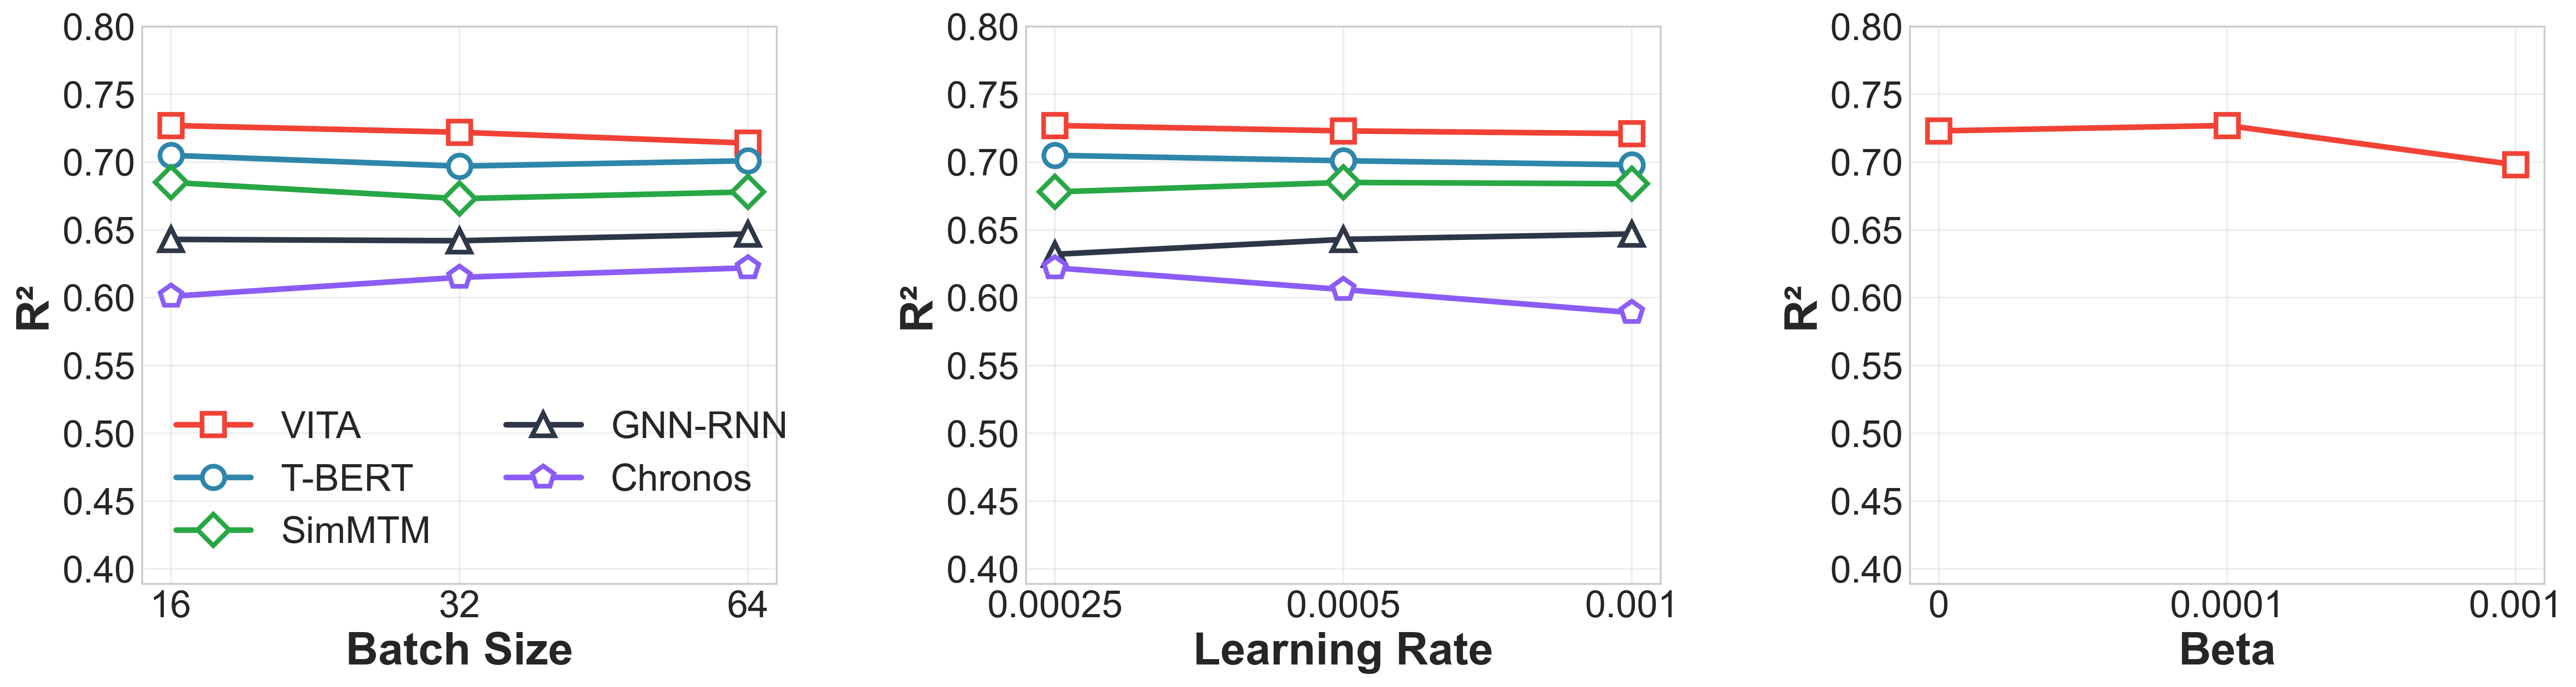

saved as '../data/latex/img/grid_search_soybean_usa.pdf'


In [285]:
# Create the professional neurips-style plot - all styling handled by rcParams
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Plot 1: Batch Size vs R² (legend only here) - dynamic model plotting
x_batch = np.arange(len(batch_sizes))
for model_key in model_data.keys():
    if model_key in batch_results:  # Only plot if we have data
        display_name = AVAILABLE_MODELS[model_key]['display_name']
        color = AVAILABLE_MODELS[model_key]['color']
        marker = AVAILABLE_MODELS[model_key]['marker']
        ax1.plot(x_batch, batch_results[model_key], color=color, marker=marker, 
                 label=display_name, markerfacecolor='white', markeredgecolor=color)

ax1.set_xlabel('Batch Size')
ax1.set_ylabel('R²')
ax1.set_xticks(x_batch)
ax1.set_xticklabels(batch_sizes)
ax1.legend(loc='lower left', ncol=2)

# Plot 2: Learning Rate vs R² (no legend) - dynamic model plotting
x_lr = np.arange(len(learning_rates))
for model_key in model_data.keys():
    if model_key in lr_results:  # Only plot if we have data
        display_name = AVAILABLE_MODELS[model_key]['display_name']
        color = AVAILABLE_MODELS[model_key]['color']
        marker = AVAILABLE_MODELS[model_key]['marker']
        ax2.plot(x_lr, lr_results[model_key], color=color, marker=marker, 
                 markerfacecolor='white', markeredgecolor=color)

ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('R²')
ax2.set_xticks(x_lr)
ax2.set_xticklabels(['0.00025', '0.0005', '0.001'])

# Plot 3: Beta vs R² (WeatherFormer only if available, no legend)
x_beta = np.arange(len(betas))
if beta_weatherformer_r2 and 'weatherformer' in model_data:
    wf_color = AVAILABLE_MODELS['weatherformer']['color']
    wf_marker = AVAILABLE_MODELS['weatherformer']['marker']
    ax3.plot(x_beta, beta_weatherformer_r2, color=wf_color, marker=wf_marker, 
             markerfacecolor='white', markeredgecolor=wf_color)

ax3.set_xlabel('Beta')
ax3.set_ylabel('R²')
ax3.set_xticks(x_beta)
ax3.set_xticklabels(['0', '0.0001', '0.001'])

# Automated y-axis configuration based on R² values
def calculate_y_axis_config(batch_results, lr_results, beta_weatherformer_r2):
    """
    Calculate automated y-axis limits and ticks based on R² values.
    
    Args:
        batch_results: dict of model_key -> list of R² values
        lr_results: dict of model_key -> list of R² values  
        beta_weatherformer_r2: list of R² values for beta analysis
    
    Returns:
        tuple: (y_min, y_max, y_ticks)
    """
    # Collect all R² values from all data sources
    all_r2_values = []
    
    # Add batch results
    for model_values in batch_results.values():
        all_r2_values.extend(model_values)
    
    # Add learning rate results
    for model_values in lr_results.values():
        all_r2_values.extend(model_values)
    
    # Add beta results if available
    if beta_weatherformer_r2:
        all_r2_values.extend(beta_weatherformer_r2)
    
    # Calculate min and max
    min_r2 = min(all_r2_values)
    max_r2 = max(all_r2_values)
    
    # Set y_min to min_r2 - 0.2 (space for legends)
    y_min = min_r2 - 0.2
    
    # Round y_max up to nearest multiple of 0.05
    y_max = np.ceil(max_r2 / 0.05+ 1) * 0.05
    
    # Generate ticks 5 points apart (0.05 spacing)
    y_ticks = np.arange(np.ceil(y_min / 0.05) * 0.05, y_max + 0.001, 0.05)
    
    return y_min, y_max, y_ticks

# Apply automated y-axis configuration
y_min, y_max, y_ticks = calculate_y_axis_config(batch_results, lr_results, beta_weatherformer_r2)
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(y_ticks)

# Create output directory if it doesn't exist
import os
os.makedirs('../data/latex/img', exist_ok=True)

# Adjust layout and save
plt.tight_layout(pad=2.0)
filename = f'../data/latex/img/grid_search_{crop_type}_{country_name}.pdf'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"saved as '{filename}'")


In [286]:
import json

# Dynamic JSON loading for individual R² values
json_data = {}
for model_key in model_data.keys():
    file_key = AVAILABLE_MODELS[model_key]['file_key']
    try:
        with open(f'data/grid_search_{file_key}_pretrained_{crop_type}_{country_name}.json', 'r') as f:
            json_data[model_key] = json.load(f)
        print(f"✓ Loaded JSON data for {AVAILABLE_MODELS[model_key]['display_name']}")
    except FileNotFoundError:
        print(f"✗ Warning: Could not find JSON file for {AVAILABLE_MODELS[model_key]['display_name']}")
        continue

# Find the best performing model for each type based on mean R²
best_configs = {}
best_r2s = {}

# Find best configuration for each model
for model_key, data in json_data.items():
    best_config = None
    best_r2 = -1
    for config_name, results in data.items():
        mean_r2 = results[YEAR_STR]['mean_r2']
        if mean_r2 > best_r2:
            best_r2 = mean_r2
            best_config = config_name
    best_configs[model_key] = best_config
    best_r2s[model_key] = best_r2

# Print results dynamically
for model_key in json_data.keys():
    display_name = AVAILABLE_MODELS[model_key]['display_name']
    print(f"Best {display_name} configuration: {best_configs[model_key]}")
    print(f"Best {display_name} mean R²: {best_r2s[model_key]:.3f}")

# Extract individual R² values for the best configurations
best_individual_r2 = {}
for model_key in json_data.keys():
    best_individual_r2[model_key] = json_data[model_key][best_configs[model_key]][YEAR_STR]['individual_r2_values']

print(f"\nBest individual R² values:")
for model_key in json_data.keys():
    display_name = AVAILABLE_MODELS[model_key]['display_name']
    print(f"Best {display_name} individual R² values: {best_individual_r2[model_key]}")


✓ Loaded JSON data for VITA
✓ Loaded JSON data for T-BERT
✓ Loaded JSON data for SimMTM
✓ Loaded JSON data for GNN-RNN
✓ Loaded JSON data for Chronos
Best VITA configuration: weatherformersinusoid_pretrained_soybean_beta_0.0001_bs_16_lr_0.00025
Best VITA mean R²: 0.727
Best T-BERT configuration: bert_pretrained_soybean_beta_0.0_bs_16_lr_0.00025
Best T-BERT mean R²: 0.705
Best SimMTM configuration: simmtm_pretrained_soybean_beta_0.0_bs_16_lr_0.0005
Best SimMTM mean R²: 0.685
Best GNN-RNN configuration: gnnrnn_pretrained_soybean_beta_0.0_bs_64_lr_0.001
Best GNN-RNN mean R²: 0.647
Best Chronos configuration: chronos_pretrained_soybean_beta_0.0_bs_64_lr_0.00025
Best Chronos mean R²: 0.622

Best individual R² values:
Best VITA individual R² values: [0.5871269504573595, 0.7112002347619198, 0.8089631747238377, 0.6937977391126908, 0.8360521193017281]
Best T-BERT individual R² values: [0.5100715366716411, 0.6617667723559935, 0.775661974911123, 0.7285652996276953, 0.8478268398239197]
Best SimMTM

In [287]:
# Increase legend, ticks, and axis labels by 50% for individual plot
plt.rcParams.update({
    'axes.labelsize': 36,      # 24 * 1.5
    'xtick.labelsize': 30,     # 20 * 1.5  
    'ytick.labelsize': 30,     # 20 * 1.5
    'legend.fontsize': 30,     # 20 * 1.5
})


✓ Loaded best_config_tests for VITA (3 seeds)
✓ Loaded best_config_tests for T-BERT (3 seeds)
✓ Loaded best_config_tests for SimMTM (3 seeds)
✓ Loaded best_config_tests for GNN-RNN (3 seeds)
✓ Loaded best_config_tests for Chronos (3 seeds)
VITA: [0.57862351 0.71761642 0.78910816 0.68915599 0.83404871]
T-BERT: [0.48432601 0.67604388 0.7731944  0.7116011  0.82011569]
SimMTM: [0.48757796 0.637273   0.77284617 0.70707632 0.83260901]
GNN-RNN: [0.33145191 0.60417723 0.75478597 0.71864034 0.79169488]
Chronos: [0.6598675  0.51839543 0.71373379 0.61509274 0.59717528]


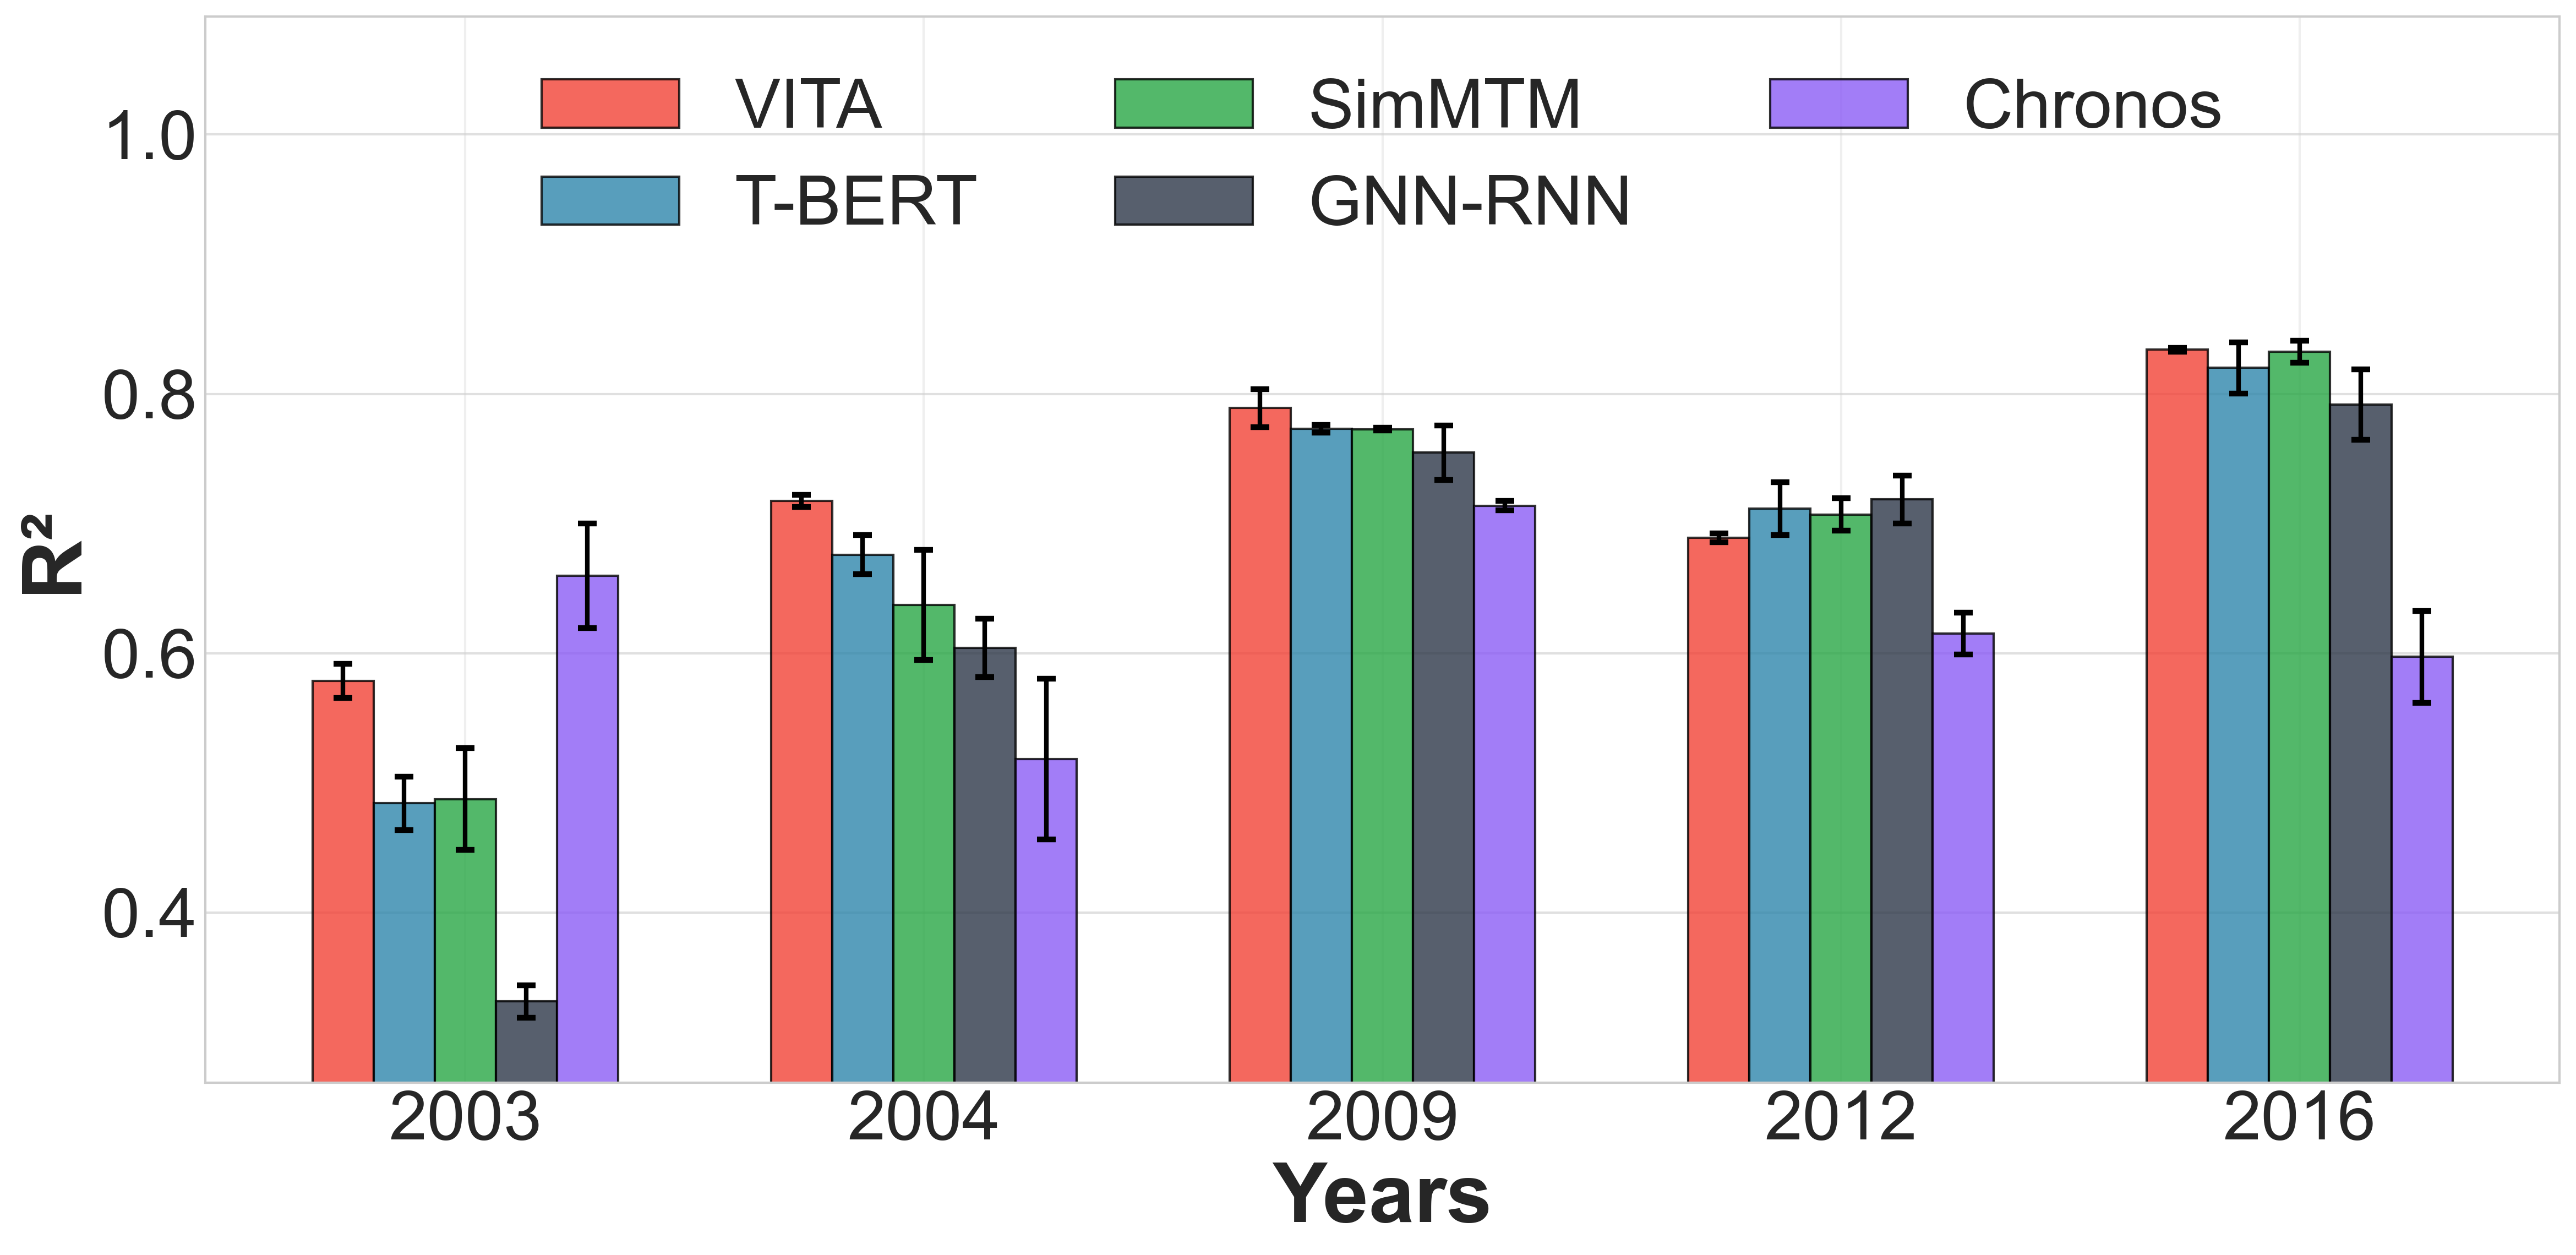

Bar plot saved as '../data/latex/img/individual_r2_comparison_soybean_usa.pdf'


In [288]:
# Load best_config_tests data if available, otherwise use grid search data
best_config_data = {}
best_config_errors = {}

for model_key in SELECTED_MODELS:
    file_key = AVAILABLE_MODELS[model_key]['file_key']
    # Construct best_config_tests filename
    test_type = "extreme_weather_cutoff"
    best_config_filename = f'data/best_config_tests/best_config_tests_{file_key}_{crop_type}_{country_name}_{test_type}_detailed.json'
    
    try:
        with open(best_config_filename, 'r') as f:
            best_config_json = json.load(f)
        
        # Extract individual R² values for each seed
        seed_data = []
        for seed_key, seed_results in best_config_json.items():
            seed_data.append(seed_results['individual_r2_values'])
        
        # Calculate mean and std across seeds for each fold
        seed_data = np.array(seed_data)  # shape: (n_seeds, n_folds)
        best_config_data[model_key] = seed_data.mean(axis=0)  # mean across seeds
        best_config_errors[model_key] = seed_data.std(axis=0)  # std across seeds
        
        print(f"✓ Loaded best_config_tests for {AVAILABLE_MODELS[model_key]['display_name']} ({len(best_config_json)} seeds)")
        
    except FileNotFoundError:
        # Fall back to grid search JSON data (no error bars)
        if model_key in best_individual_r2:
            best_config_data[model_key] = best_individual_r2[model_key]
            best_config_errors[model_key] = None
            print(f"✗ No best_config_tests found for {AVAILABLE_MODELS[model_key]['display_name']}, using grid search JSON data")
        else:
            print(f"✗ No data found for {AVAILABLE_MODELS[model_key]['display_name']}, skipping")

# Create bar plot for individual R² values - neurips style
fig, ax = plt.subplots(figsize=(16, 8))

# Get available models with individual R² data
available_models = list(best_config_data.keys())
if not available_models:
    print("No individual R² data available for plotting")
else:
    # Number of folds (use first available model to get fold count)
    n_folds = len(best_config_data[available_models[0]])
    fold_labels = [str(year) for year in EXTREME_YEARS[country_name][crop_type]]
    
    # Set up bar positions dynamically based on number of models
    x = np.arange(n_folds) * 0.6  # Multiply by 0.6 to bring year groups closer
    n_models = len(available_models)
    width = 0.08 if n_models <= 5 else 0.06  # Adjust width based on number of models
    
    # Create bars using dynamic model list (optionally exclude GNN-RNN for visual clarity)
    bar_model_keys = [key for key in available_models if key != 'gnnrnn1']
    bars = []
    
    for i, model_key in enumerate(bar_model_keys):
        display_name = AVAILABLE_MODELS[model_key]['display_name']
        color = AVAILABLE_MODELS[model_key]['color']
        offset = (i - (len(bar_model_keys) - 1) / 2) * width  # Center the bars around x
        
        # Add error bars if available
        yerr = best_config_errors[model_key] if best_config_errors[model_key] is not None else None
        print(f"{display_name}: {best_config_data[model_key]}")
        bar = ax.bar(x + offset, best_config_data[model_key], width, 
                     label=display_name, color=color, alpha=0.8, edgecolor='black',
                     yerr=yerr, capsize=4, error_kw={'linewidth': 2, 'elinewidth': 2})
        bars.append(bar)
    
    # Customize the plot - no title for neurips style
    ax.set_xlabel('Years')
    ax.set_ylabel('R²')
    ax.set_xticks(x)
    ax.set_xticklabels(fold_labels)
    ax.legend(loc='upper center', ncol=min(3, len(bar_model_keys)), frameon=False)
    
    # Remove gnnrnn from best_config_data for y-axis calculation (if it exists)
    plot_r2_data = {k: v for k, v in best_config_data.items() if k in bar_model_keys}
    
    # Set y-axis limits to better show the data (accounting for error bars)
    all_r2_values = []
    for model_key in plot_r2_data.keys():
        all_r2_values.extend(best_config_data[model_key])
        # Add error bars to min/max calculation if available
        if best_config_errors[model_key] is not None:
            all_r2_values.extend(best_config_data[model_key] + best_config_errors[model_key])
            all_r2_values.extend(best_config_data[model_key] - best_config_errors[model_key])
    
    if all_r2_values:
        ax.set_ylim(min(all_r2_values) - 0.05, max(all_r2_values) + 0.25)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.6, axis='y')
    
    plt.tight_layout()
    save_path = f'../data/latex/img/individual_r2_comparison_{crop_type}_{country_name}.pdf'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Bar plot saved as '{save_path}'")


In [289]:
# Compute mean and standard deviation of running time in minutes from JSON files
import numpy as np

def extract_runtime_minutes(json_data, batch_size=32):
    """Extract runtime minutes from JSON data, filtered by batch size for fairness"""
    runtimes = []
    for config_name, results in json_data.items():
        # Filter for specific batch size only for fair comparison
        if f'_bs_{batch_size}_' in config_name:
            if YEAR_STR in results and 'runtime_seconds' in results[YEAR_STR]:
                runtime_minutes = results[YEAR_STR]['runtime_seconds'] / 60.0
                runtimes.append(runtime_minutes)
    return runtimes

def print_runtime_stats(runtimes, model_name, prefix="\n"):
    """Print runtime statistics for a given model"""
    if runtimes:
        mean = np.mean(runtimes)
        std = np.std(runtimes, ddof=1)  # sample standard deviation
        print(f"{prefix}{model_name}:")
        print(f"  Mean: {mean:.2f} minutes")
        print(f"  Std:  {std:.2f} minutes")
    else:
        print(f"{prefix}{model_name}: No runtime data found")

# Extract runtime data for each model dynamically
runtime_data = {}
for model_key in json_data.keys():
    runtime_data[model_key] = extract_runtime_minutes(json_data[model_key])

# Compute statistics
print("Running Time Statistics (in minutes):")
print("=" * 50)

for model_key in runtime_data.keys():
    display_name = AVAILABLE_MODELS[model_key]['display_name']
    print_runtime_stats(runtime_data[model_key], display_name, prefix="")

# Overall statistics across all models
all_runtimes = []
for runtimes in runtime_data.values():
    all_runtimes.extend(runtimes)

if all_runtimes:
    overall_mean = np.mean(all_runtimes)
    overall_std = np.std(all_runtimes, ddof=1)
    print(f"\nOverall (all models, batch size 32):")
    print(f"  Mean: {overall_mean:.2f} minutes")
    print(f"  Std:  {overall_std:.2f} minutes")
    print(f"  Total experiments: {len(all_runtimes)}")


Running Time Statistics (in minutes):
VITA:
  Mean: 25.53 minutes
  Std:  0.58 minutes
T-BERT:
  Mean: 24.69 minutes
  Std:  0.13 minutes
SimMTM:
  Mean: 25.92 minutes
  Std:  0.01 minutes
GNN-RNN:
  Mean: 7.92 minutes
  Std:  0.25 minutes
Chronos:
  Mean: 43.05 minutes
  Std:  0.31 minutes

Overall (all models, batch size 32):
  Mean: 25.45 minutes
  Std:  9.64 minutes
  Total experiments: 21


In [290]:
import pandas as pd
from scipy.stats import ttest_ind

def evaluate_pretraining_effect(model_name, crop_type):
    """
    Evaluate the effect of pretraining on a given model.
    
    Args:
        model_name (str): Name of the model ('bert', 'weatherformersinusoid', 'simmtm', 'gnnrnn')
    
    Returns:
        dict: Statistics comparing pretrained vs not-pretrained performance
    """
    # Construct file paths based on model name and crop_type
    not_pretrained_path = f'data/grid_search_{model_name}_not_pretrained_{crop_type}_{country_name}.tsv'
    pretrained_path = f'data/grid_search_{model_name}_pretrained_{crop_type}_{country_name}.tsv'
    
    try:
        # Load data
        df_not_pretrained = pd.read_csv(not_pretrained_path, sep='\t')
        df_pretrained = pd.read_csv(pretrained_path, sep='\t')
        
        # Extract R^2 values using the same pattern as existing code
        r2_not_pretrained = df_not_pretrained[f'{YEAR_STR}_r2'].str.split(' ± ').str[0].astype(float)
        r2_pretrained = df_pretrained[f'{YEAR_STR}_r2'].str.split(' ± ').str[0].astype(float)
        
        # Compute statistics
        stats = {
            'model_name': model_name,
            'crop_type': crop_type,
            'not_pretrained': {
                'mean_r2': r2_not_pretrained.mean(),
                'std_r2': r2_not_pretrained.std(),
                'best_r2': r2_not_pretrained.max(),
                'n_experiments': len(r2_not_pretrained)
            },
            'pretrained': {
                'mean_r2': r2_pretrained.mean(),
                'std_r2': r2_pretrained.std(),
                'best_r2': r2_pretrained.max(),
                'n_experiments': len(r2_pretrained)
            }
        }
        
        # Perform t-test
        t_stat, p_val = ttest_ind(r2_pretrained, r2_not_pretrained, equal_var=False)
        stats['t_stat'] = t_stat
        stats['p_val'] = p_val
        
        # Calculate improvement
        stats['improvement'] = {
            'mean_diff': stats['pretrained']['mean_r2'] - stats['not_pretrained']['mean_r2'],
            'percent_improvement': ((stats['pretrained']['mean_r2'] - stats['not_pretrained']['mean_r2']) / stats['not_pretrained']['mean_r2']) * 100,
            'best_diff': stats['pretrained']['best_r2'] - stats['not_pretrained']['best_r2']
        }
        
        return stats
        
    except FileNotFoundError as e:
        print(f"Error: Could not find data files for model '{model_name}'")
        print(f"Expected files:")
        print(f"  - {not_pretrained_path}")
        print(f"  - {pretrained_path}")
        return None
    except Exception as e:
        print(f"Error processing data for model '{model_name}': {str(e)}")
        return None

# Dynamic pretraining evaluation for selected models and current crop
print(f"Testing pretraining effect evaluation for {crop_type}...")
print("=" * 50)

for model_key in model_data.keys():
    file_key = AVAILABLE_MODELS[model_key]['file_key']
    display_name = AVAILABLE_MODELS[model_key]['display_name']
    
    print(f"\nEvaluating {display_name}...")
    test_result = evaluate_pretraining_effect(file_key, crop_type)
    if test_result:
        print(f"Model: {test_result['model_name']}")
        print(f"Crop: {test_result['crop_type']}")
        print(f"Not pretrained - Mean R²: {test_result['not_pretrained']['mean_r2']:.3f} ± {test_result['not_pretrained']['std_r2']:.3f}")
        print(f"Not pretrained - Best R²: {test_result['not_pretrained']['best_r2']:.3f}")
        print(f"Pretrained - Mean R²: {test_result['pretrained']['mean_r2']:.3f} ± {test_result['pretrained']['std_r2']:.3f}")
        print(f"Pretrained - Best R²: {test_result['pretrained']['best_r2']:.3f}")
        print(f"Mean Improvement: {test_result['improvement']['mean_diff']:.3f} ({test_result['improvement']['percent_improvement']:.1f}%)")
        print(f"Best Improvement: {test_result['improvement']['best_diff']:.3f}")
        print(f"T-test: t={test_result['t_stat']:.2f}, p={test_result['p_val']}")
        if test_result['p_val'] < 0.05:
            print("Statistical significance: p < 0.05 (significant)")
        else:
            print("Statistical significance: p ≥ 0.05 (not significant)")
    else:
        print(f"Could not evaluate pretraining effect for {display_name}")


Testing pretraining effect evaluation for soybean...

Evaluating VITA...
Model: weatherformersinusoid
Crop: soybean
Not pretrained - Mean R²: 0.569 ± 0.139
Not pretrained - Best R²: 0.684
Pretrained - Mean R²: 0.698 ± 0.019
Pretrained - Best R²: 0.727
Mean Improvement: 0.129 (22.7%)
Best Improvement: 0.043
T-test: t=4.80, p=5.2518551332464655e-05
Statistical significance: p < 0.05 (significant)

Evaluating T-BERT...
Model: weatherautoencoder
Crop: soybean
Not pretrained - Mean R²: 0.660 ± 0.020
Not pretrained - Best R²: 0.680
Pretrained - Mean R²: 0.693 ± 0.012
Pretrained - Best R²: 0.705
Mean Improvement: 0.033 (5.1%)
Best Improvement: 0.025
T-test: t=4.36, p=0.0007551971169972616
Statistical significance: p < 0.05 (significant)

Evaluating SimMTM...
Model: simmtm
Crop: soybean
Not pretrained - Mean R²: 0.660 ± 0.020
Not pretrained - Best R²: 0.680
Pretrained - Mean R²: 0.672 ± 0.010
Pretrained - Best R²: 0.685
Mean Improvement: 0.012 (1.8%)
Best Improvement: 0.005
T-test: t=1.59, p=0